In [1]:
%load_ext autoreload
%autoreload 2

This notebook will showcase the performance of a single run of test set - Bootstrap, k-fold cross validation, and a Dirichlet-Multinomial model for estimating the distribution of the confusion matrix in binary classification.

In [40]:
import itertools as it
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns

from scipy.stats import levene
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from mmur.simulators import LAlgorithm
from mmur.generators import BlobGenerator
from mmur.methods import single_run as sr

First, consider only the randomness due to test set sampling. We keep a fixed train set, and attempt to predict how well a classifier predicts on new test data (from the same data distribution)

In [116]:
def cms_to_precision(cms):
    """
        Computes the precisions based on a list of confusion matrices

        Parameters
        cms : list
            List of (2 by 2) confusion matrices, where each confusion matrix is a list with two sublists
            of length 2, containing the counts. [[true negatives,false positives],[false negatives,true positives]]

        Returns
        TP/(TP+FP) : ndarray
            1D numpy array of precisions
        """

    # cms_array = np.array(cms)
    TP = cms[:, 3]
    FP = cms[:, 1]
    return TP/(TP+FP)

def run_sr_methods(X,y,model_class,train_size,model_kwargs = {},n_bs_draws = 1, n_cv_splits = 5,random_state=None):

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = model_class(**model_kwargs).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test,y_pred).flatten()

    cm_bs = sr.bstrp_cm(cm_test, n_bs_draws, random_state)
    cm_cv = sr.kfold_cm(X, y, model_class, model_kwargs, n_cv_splits, random_state)

    return cm_test, cm_bs, cm_cv

In [65]:
# Generate data from Gaussian blobs
generator = BlobGenerator(6000,int(1000 * 1e4),weights=[0.8,0.2])
X,y = generator.make_classification(1)

# Known data sample, used for train + test
X_in, y_in = X[:6000], y[:6000]

# Unknown data samples, used to evaluate true model performance
X_out, y_out = X[6000:].reshape((-1, 1000, 2)), y[6000:].reshape((-1, 1000))

# Train/test split
X_train, X_test = X_in[:5000], X_in[5000:6000]
y_train, y_test = y_in[:5000], y_in[5000:6000]

In [54]:
model_class = LogisticRegression
model_kwargs = {'penalty':'none'}
model = model_class(**model_kwargs).fit(X_train,y_train)

y_pred = model.predict(X_out.reshape((-1,2))).reshape((-1,1000))
cm_true = np.zeros((y_pred.shape[0],4),dtype=int)
for i,(true,predicted) in enumerate(zip(y_out,y_pred)):
    cm_true[i,:] = confusion_matrix(true,predicted).flatten()

In [90]:
def quantile_iv(values,qrange = 0.95):
    """produces an interval based on a median-centered quantile range

    Parameters
    ----------
    values : _type_
        _description_
    qrange : float, optional
        _description_, by default 0.95

    Returns
    -------
    _type_
        _description_
    """
    upper = np.quantile(values,(1-qrange)/2)
    lower = np.quantile(values,1-(1-qrange)/2)
    return upper,lower

In [122]:
cm_test, cm_bs, cm_cv = run_sr_methods(X_in,y_in,LogisticRegression,5000,{'penalty':'none'},1000,6,1)
prec_test, precs_bs,precs_cv = cms_to_precision(cm_test.reshape(-1,4))[0], cms_to_precision(cm_bs),cms_to_precision(cm_cv)

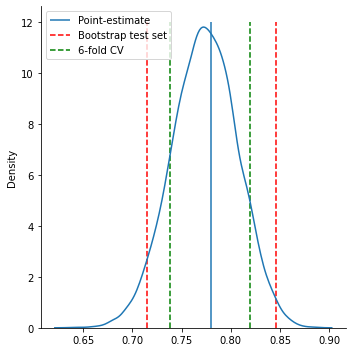

In [127]:
precs_true = cms_to_precision(cm_true)

sns.displot(precs_true, kind='kde')


plt.vlines(prec_test, 0, 12, label = 'Point-estimate')
plt.vlines(quantile_iv(precs_bs), 0, 12, colors = 'red', linestyles='dashed',label='Bootstrap test set')
plt.vlines(quantile_iv(precs_cv), 0, 12, colors='green', linestyles='dashed',label='6-fold CV')
plt.legend()

In [128]:
interval=quantile_iv(precs_bs)
interval

(0.7152777777777778, 0.8461656441717791)

In [91]:
quantile_iv(cms_to_precision(cm_cv), 0.95)


(0.7379082039028276, 0.8198252884474952)